In [4]:
import sys
from pathlib import Path
import pyarrow.parquet as pq
import pyarrow.dataset as ds
import pandas as pd
import matplotlib.pyplot as plt
sys.path.append(str(Path.cwd().parent))
from config import PATH_KIOSK_USER_PATTERNS_FOLDER, PATH_KIOSK_USER_PATTERNS_REPO

# Example usage
ekdat02_path = PATH_KIOSK_USER_PATTERNS_FOLDER / "working/raw" / "ekdat02"
ekdat02_supplemental_path = PATH_KIOSK_USER_PATTERNS_FOLDER / "working/raw" / "ekdat02-supplemental"

In [2]:
# Load the Parquet dataset ekdat02
ekdat02_dataset = ds.dataset(ekdat02_path, format="parquet")

In [2]:
# Load the Parquet dataset ekdat02_supplemental
ekdat02_supplemental_dataset = ds.dataset(ekdat02_supplemental_path, format="parquet")

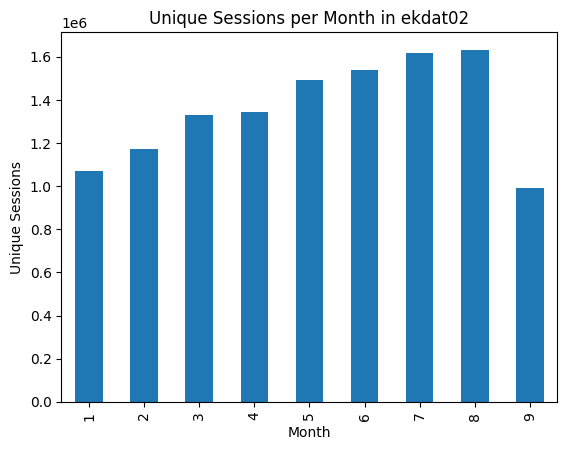

In [ ]:


# Plot the number of unique sessions per month in ekdat02
# Load only the required columns to reduce memory usage
scanner = ekdat02_dataset.scanner(columns=['session_id_mask', 'session_received_utc'])
ekdat02_df = scanner.to_table().to_pandas()

# Ensure 'session_received_utc' is datetime, then extract the month
ekdat02_df['session_received_utc'] = pd.to_datetime(ekdat02_df['session_received_utc'], errors='coerce')
ekdat02_df['month'] = ekdat02_df['session_received_utc'].dt.month

# Group by month and count unique session IDs
sessions_per_month = ekdat02_df.groupby('month')['session_id_mask'].nunique()
sessions_per_month.plot(kind='bar')
plt.xlabel('Month')
plt.ylabel('Unique Sessions')
plt.title('Unique Sessions per Month in ekdat02')
plt.show()

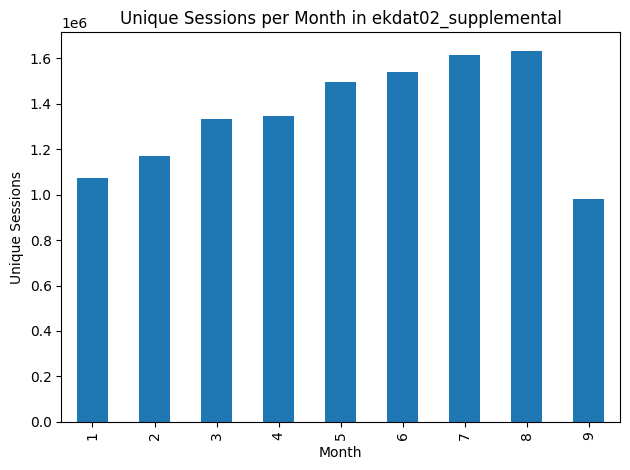

In [5]:
# Plot the number of unique sessions per month in ekdat02_supplemental

# Load only the required columns to reduce memory usage
scanner = ekdat02_supplemental_dataset.scanner(columns=['session_id_mask', 'date_time'])
ekdat02_supplemental_df = scanner.to_table().to_pandas()

# Ensure 'date_time' is datetime, then extract the month
ekdat02_supplemental_df['date_time'] = pd.to_datetime(ekdat02_supplemental_df['date_time'], errors='coerce')
ekdat02_supplemental_df['month'] = ekdat02_supplemental_df['date_time'].dt.month

# Group by month and count unique session IDs
sessions_per_month_supp = ekdat02_supplemental_df.groupby('month')['session_id_mask'].nunique()

# Plot
sessions_per_month_supp.plot(kind='bar')
plt.xlabel('Month')
plt.ylabel('Unique Sessions')
plt.title('Unique Sessions per Month in ekdat02_supplemental')
plt.tight_layout()
plt.show()

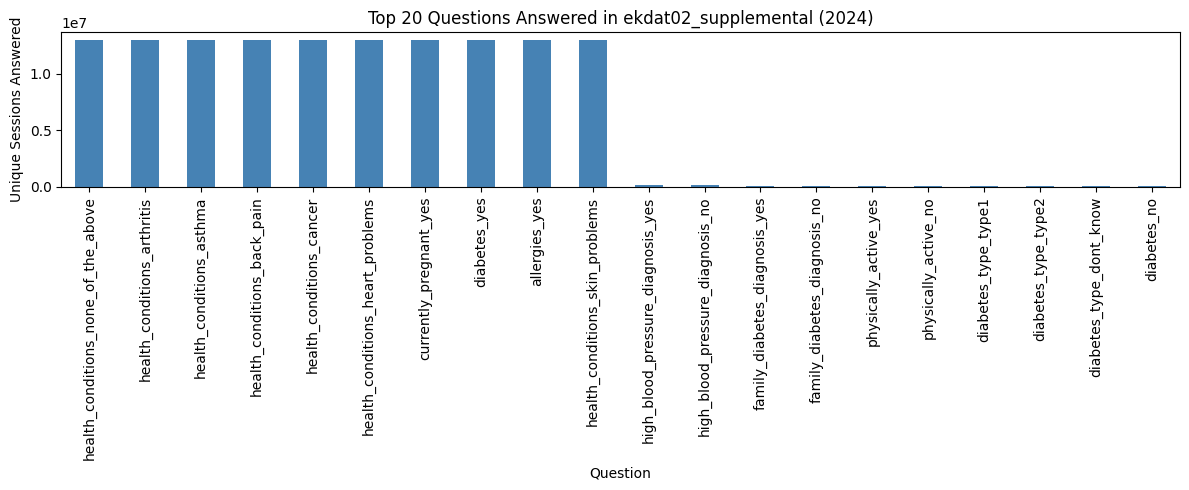

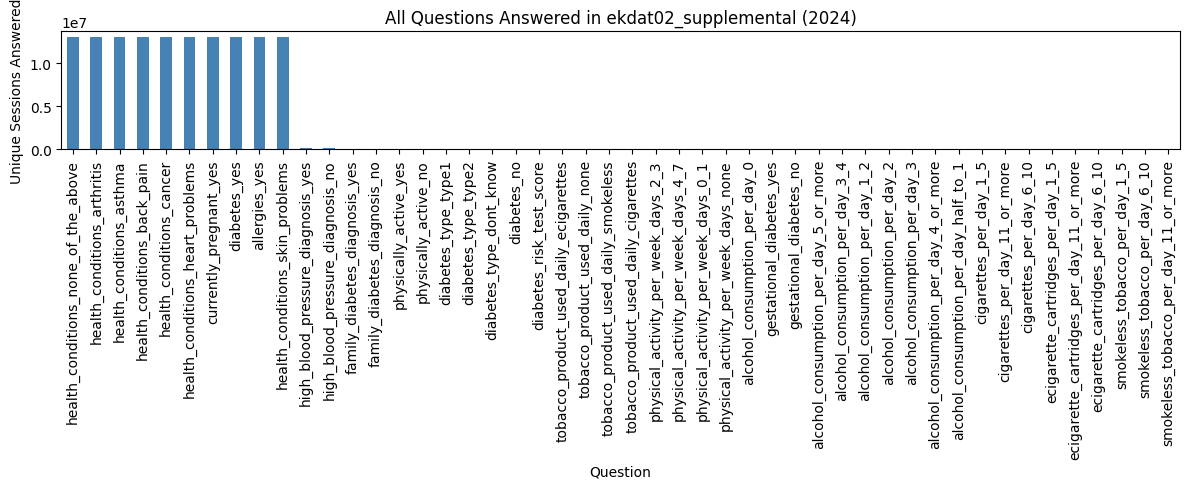

In [8]:
# Plot a bar chart of unique questions answered in ekdat02_supplemental in 2024
# === IMPORTS ===
import pyarrow as pa
import pyarrow.dataset as ds
import pyarrow.compute as pc
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# === Step 1: Create a scanner for only the columns you need ===
scanner = ekdat02_supplemental_dataset.scanner(columns=['data_label_name', 'value', 'date_time'])

# === Step 2: Read batches instead of loading all into memory ===
batches = scanner.to_batches()

# === Step 3: Use a Counter to count answers per question ===
counts = Counter()

for batch in batches:
    dt = batch['date_time']
    if dt.type.tz is not None:
        dt = pc.cast(dt, pa.timestamp('ms'))  # Cast to naive timestamp
    # Extract year from timestamp directly
    years = pc.year(dt)
    mask_2024 = pc.equal(years, 2024)

    labels = batch['data_label_name'].filter(mask_2024)
    values = batch['value'].filter(mask_2024)

    for label, val in zip(labels, values):
        if val is not None:
            counts[label.as_py()] += 1

# === Step 4: Convert to pandas and plot ===
top_questions = pd.Series(counts).sort_values(ascending=False).head(20)

plt.figure(figsize=(12, 5))
top_questions.plot(kind='bar', color='steelblue')
plt.xlabel('Question')
plt.ylabel('Unique Sessions Answered')
plt.title('Top 20 Questions Answered in ekdat02_supplemental (2024)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Plot all unique questions answered in ekdat02_supplemental in 2024 (not just top 20)
plt.figure(figsize=(max(12, len(counts) // 4), 5))
pd.Series(counts).sort_values(ascending=False).plot(kind='bar', color='steelblue')
plt.xlabel('Question')
plt.ylabel('Unique Sessions Answered')
plt.title('All Questions Answered in ekdat02_supplemental (2024)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
counts.to_csv(PATH_KIOSK_USER_PATTERNS_REPO / "data" / "kupdat02_ekdat02_supplemental counts for 2024.csv")

### Initial user patterns

There are many ways to capture user patterns. One such way is to conduct an unsupervised cluster analysis of users by what questions they chose to respond to.

1. Subset the patients for June to September 2024
2. Create a wide dataset such that each session is a row, and all questions associated with that session and its associated value is the column. Feel free to drop extra columns before that. Do let me know if you have any questions.
3. Fill in the missing values for all questions with 0
4. Run a cluster analysis so that you can see whether users responded to groups of questions and what those questions are: https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html


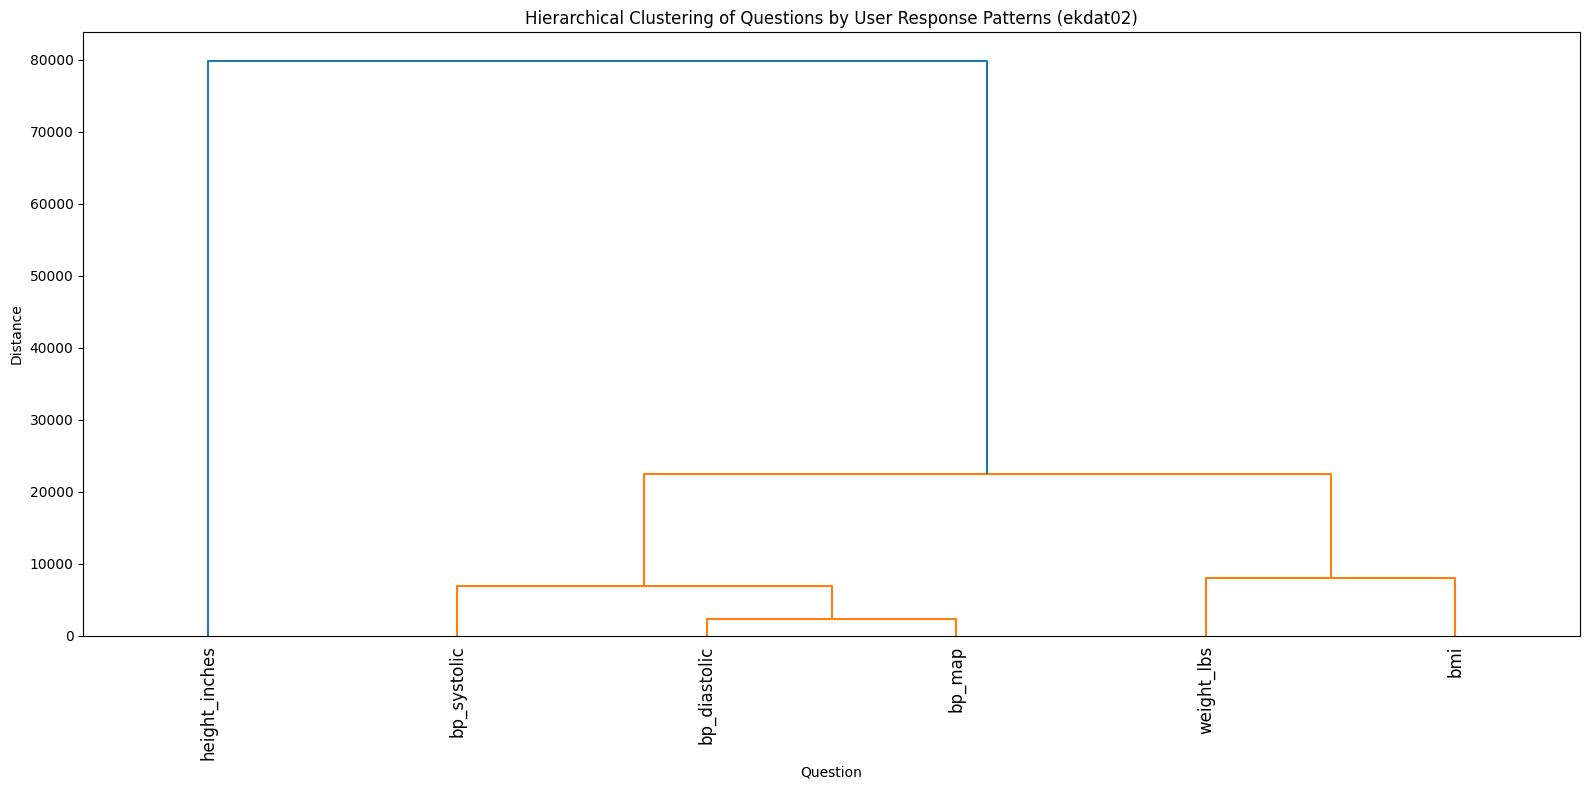

In [ ]:
 # --- IMPORTS ---
import pyarrow.dataset as ds
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram
from datetime import datetime

# --- CONFIG ---
dataset_path = ekdat02_path

# --- STEP 1: Load + Filter June–September 2024 Sessions ---
dataset = ds.dataset(dataset_path, format="parquet")
df = dataset.to_table().to_pandas()
df['session_received_utc'] = pd.to_datetime(df['session_received_utc'])

mask = (df['session_received_utc'] >= datetime(2024, 6, 1)) & (df['session_received_utc'] <= datetime(2024, 9, 30))
df = df[mask]

# --- STEP 2: Separate Metadata from Questions ---
metadata_cols = [
    'session_id_mask', 'account_id_mask', 'pseudo_member_id',
    'session_received_utc', 'session_started_local_time', 'timezone_offset',
    'location_name', 'street1', 'street2', 'city', 'state', 'zipcode',
    'birth_year', 'gender', 'ethnicity', 'year', 'month'
]
question_cols = [col for col in df.columns if col not in metadata_cols]

# --- STEP 3: Create Wide Format and Clean ---
wide_df = df[['pseudo_member_id', 'session_id_mask'] + question_cols].drop_duplicates(subset=['pseudo_member_id', 'session_id_mask']).copy()
wide_df[question_cols] = wide_df[question_cols].apply(pd.to_numeric, errors='coerce').fillna(0)

# --- STEP 4: Sample Up to 20,000 Sessions (Group First) ---
sample_df = wide_df.groupby(['pseudo_member_id', 'session_id_mask']).first().reset_index()
sample_df = sample_df.sample(n=min(20000, len(sample_df)), random_state=42)

# --- STEP 5: Transpose for Clustering ---
X = sample_df[question_cols]
X_t = X.T  # Transpose: questions as rows, users as columns

# --- STEP 6: Hierarchical Clustering ---
Z = linkage(X_t, method='ward')

# --- STEP 7: Plot Dendrogram ---
plt.figure(figsize=(16, 8))
dendrogram(Z, labels=X_t.index, leaf_rotation=90)
plt.title('Hierarchical Clustering of Questions by User Response Patterns (ekdat02)')
plt.xlabel('Question')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()

In [ ]:
# Extract unique session IDs

# Filter to sessions in June–September 2024

# Read it as a scanner and in a loop to convert it into a wide dataframe
# OR Read it as a scanner and convert directly into a wide dataframe



🚀 Starting hierarchical clustering for ekdat02_supplemental...
Step 1: Loading and filtering data...
✅ Sampled 200,000 rows from larger dataset
Filtering for June-September 2024...
✅ After date filtering: 94,791 rows
Step 2: Converting to wide format...
✅ After removing nulls: 94,791 rows
✅ Using top 30 questions, 94,586 responses
✅ Sampled 200,000 rows from larger dataset
Filtering for June-September 2024...
✅ After date filtering: 94,791 rows
Step 2: Converting to wide format...
✅ After removing nulls: 94,791 rows
✅ Using top 30 questions, 94,586 responses
✅ Wide format created: 93800 sessions × 30 questions
Step 3: Sampling sessions...
✅ Sampled to 10,000 sessions
✅ Filtered to 3 active questions
Step 4: Preparing for clustering...
✅ Matrix for clustering: 3 questions × 10000 sessions
Step 5: Running hierarchical clustering...
✅ Clustering complete!
Step 6: Creating dendrogram...
✅ Wide format created: 93800 sessions × 30 questions
Step 3: Sampling sessions...
✅ Sampled to 10,000 se

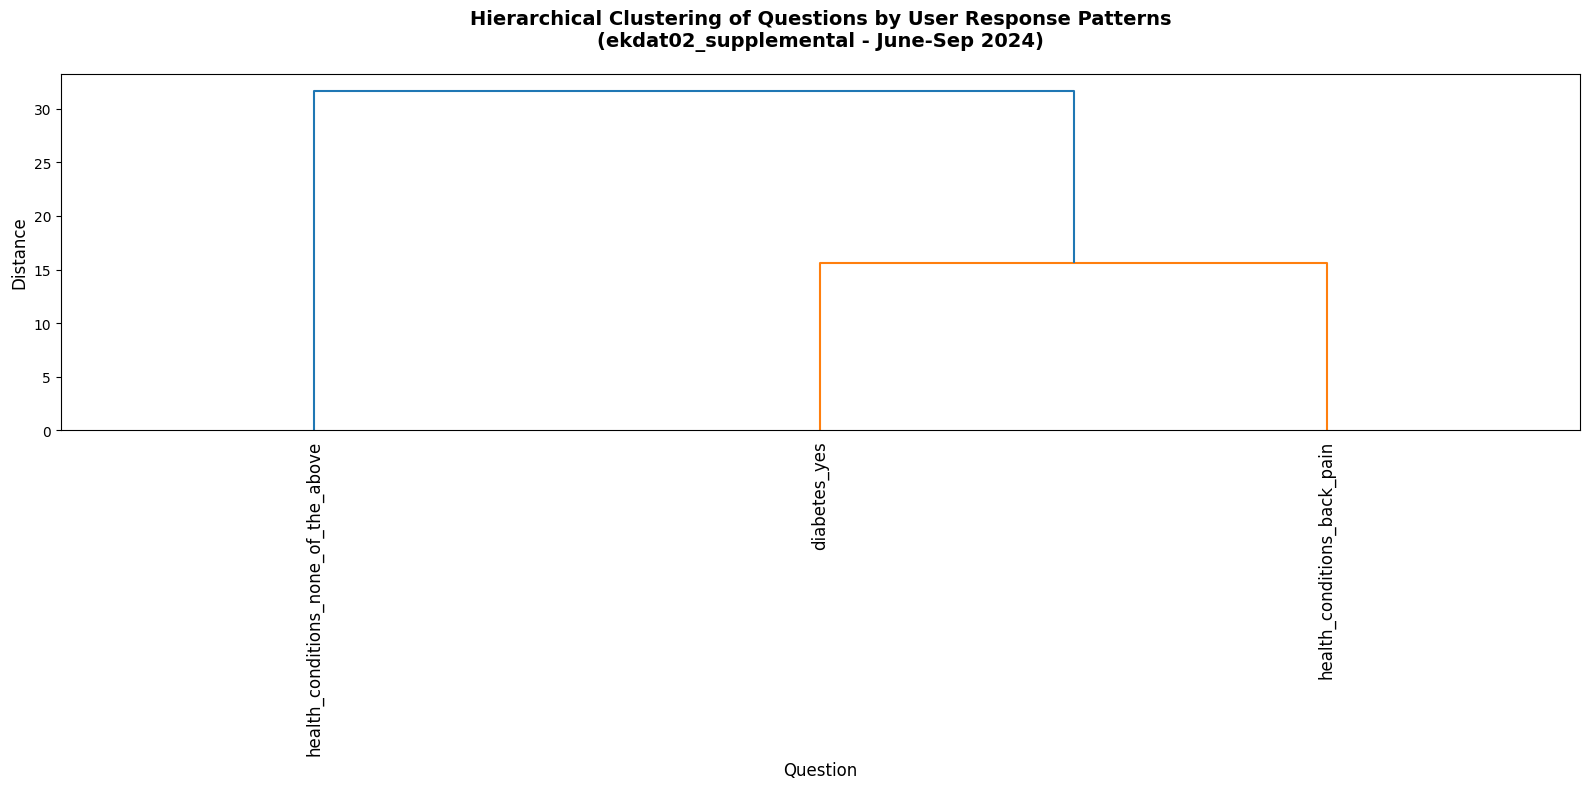

🎉 Hierarchical clustering complete!
📊 Analysis summary:
   • Total sessions analyzed: 10,000
   • Questions included: 3
   • Time period: June-September 2024
   • Dataset: ekdat02_supplemental


In [15]:
# HIERARCHICAL CLUSTERING FOR EKDAT02_SUPPLEMENTAL
# Same approach as ekdat02, but adapted for the supplemental dataset's long format

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram
from datetime import datetime

print("🚀 Starting hierarchical clustering for ekdat02_supplemental...")

# --- STEP 1: Load and Filter June–September 2024 Sessions ---
print("Step 1: Loading and filtering data...")

# Load only necessary columns for efficiency
scanner = ekdat02_supplemental_dataset.scanner(columns=['session_id_mask', 'data_label_name', 'value', 'date_time'])

# Use to_table() and then sample in pandas (more reliable than head())
try:
    # Try to get a manageable sample
    full_table = scanner.to_table()
    supp_df = full_table.to_pandas()
    
    # If dataset is too large, sample it
    if len(supp_df) > 200000:
        supp_df = supp_df.sample(n=200000, random_state=42)
        print(f"✅ Sampled {len(supp_df):,} rows from larger dataset")
    else:
        print(f"✅ Loaded {len(supp_df):,} rows")
        
except Exception as e:
    print(f"Error loading data: {e}")
    print("Trying alternative approach...")
    # Fallback: load in batches
    batches = []
    batch_count = 0
    for batch in scanner.to_batches():
        batches.append(batch)
        batch_count += 1
        if batch_count >= 10:  # Limit to first 10 batches
            break
    
    if batches:
        import pyarrow as pa
        combined_table = pa.concat_tables(batches)
        supp_df = combined_table.to_pandas()
        print(f"✅ Loaded {len(supp_df):,} rows using batch method")
    else:
        raise Exception("Could not load any data")

# Filter for June-September 2024
print("Filtering for June-September 2024...")

try:
    # Convert to datetime without forcing UTC first
    supp_df['date_time'] = pd.to_datetime(supp_df['date_time'], errors='coerce')
    
    # Create date range without timezone first
    start_date = pd.Timestamp('2024-06-01')
    end_date = pd.Timestamp('2024-09-30')
    
    # If timestamps have timezone info, convert our dates to match
    if supp_df['date_time'].dt.tz is not None:
        start_date = start_date.tz_localize('UTC')
        end_date = end_date.tz_localize('UTC')
    
    # Apply filter
    mask = (
        (supp_df['date_time'] >= start_date) & 
        (supp_df['date_time'] <= end_date)
    )
    supp_df = supp_df[mask]
    
    print(f"✅ After date filtering: {len(supp_df):,} rows")
    
except Exception as e:
    print(f"Date filtering error: {e}")
    print("Using all available data...")
    # Continue without date filtering if there's an issue

# --- STEP 2: Convert from Long to Wide Format ---
print("Step 2: Converting to wide format...")

# Check if we have any data left
if len(supp_df) == 0:
    print("❌ No data remaining after filtering. Trying without date filter...")
    # Reload without date filtering
    scanner = ekdat02_supplemental_dataset.scanner(columns=['session_id_mask', 'data_label_name', 'value', 'date_time'])
    full_table = scanner.to_table()
    supp_df = full_table.to_pandas().sample(n=min(50000, len(full_table)), random_state=42)
    print(f"✅ Using sample of {len(supp_df):,} rows without date filter")

# Remove rows with null question names or values
supp_df = supp_df.dropna(subset=['data_label_name', 'value'])
print(f"✅ After removing nulls: {len(supp_df):,} rows")

# Check if we still have data
if len(supp_df) == 0:
    raise Exception("No valid data found. Check your dataset structure.")

# Get top 30 most common questions to keep analysis manageable
top_questions = supp_df['data_label_name'].value_counts().head(30).index
supp_filtered = supp_df[supp_df['data_label_name'].isin(top_questions)]

print(f"✅ Using top 30 questions, {len(supp_filtered):,} responses")

try:
    # Pivot to wide format: sessions as rows, questions as columns
    wide_df = supp_filtered.pivot_table(
        index='session_id_mask', 
        columns='data_label_name', 
        values='value', 
        aggfunc='first'  # Take first value if duplicate
    )
    
    # Fill missing values with 0 and convert to numeric
    wide_df = wide_df.apply(pd.to_numeric, errors='coerce').fillna(0)
    
    print(f"✅ Wide format created: {wide_df.shape[0]} sessions × {wide_df.shape[1]} questions")
    
except Exception as e:
    print(f"Pivot error: {e}")
    print("Trying alternative pivot approach...")
    
    # Alternative approach: create dummy variables
    wide_df = pd.get_dummies(supp_filtered.set_index('session_id_mask')['data_label_name'])
    wide_df = wide_df.groupby(level=0).sum()  # Sum duplicates
    print(f"✅ Alternative wide format created: {wide_df.shape[0]} sessions × {wide_df.shape[1]} questions")

# --- STEP 3: Sample Sessions for Clustering ---
print("Step 3: Sampling sessions...")

# Sample up to 10,000 sessions for manageable clustering
if len(wide_df) > 10000:
    wide_df = wide_df.sample(n=10000, random_state=42)
    print(f"✅ Sampled to {len(wide_df):,} sessions")

# Remove questions with very low response rates (less than 1% of sessions)
min_responses = len(wide_df) * 0.01
question_response_counts = (wide_df > 0).sum()
active_questions = question_response_counts[question_response_counts >= min_responses].index
wide_df = wide_df[active_questions]

print(f"✅ Filtered to {len(active_questions)} active questions")

# --- STEP 4: Transpose for Clustering (Questions as Rows) ---
print("Step 4: Preparing for clustering...")

X = wide_df
X_t = X.T  # Transpose: questions as rows, sessions as columns

print(f"✅ Matrix for clustering: {X_t.shape[0]} questions × {X_t.shape[1]} sessions")

# --- STEP 5: Hierarchical Clustering ---
print("Step 5: Running hierarchical clustering...")

Z = linkage(X_t, method='ward')

print("✅ Clustering complete!")

# --- STEP 6: Plot Dendrogram ---
print("Step 6: Creating dendrogram...")

plt.figure(figsize=(16, 8))
dendrogram(Z, labels=X_t.index, leaf_rotation=90)
plt.title('Hierarchical Clustering of Questions by User Response Patterns\n(ekdat02_supplemental - June-Sep 2024)', 
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Question', fontsize=12)
plt.ylabel('Distance', fontsize=12)
plt.tight_layout()
plt.show()

print("🎉 Hierarchical clustering complete!")
print(f"📊 Analysis summary:")
print(f"   • Total sessions analyzed: {len(wide_df):,}")
print(f"   • Questions included: {len(active_questions)}")
print(f"   • Time period: June-September 2024")
print(f"   • Dataset: ekdat02_supplemental")

Creating unified clustering with all questions from both datasets...
Total unique questions across both datasets: 9
Questions from ekdat02: 6
Questions from supplemental: 3
Creating combined matrix...
Combined matrix shape: (30000, 9)
Sampling 5000 rows from 30000 total rows...
Final matrix for clustering: (5000, 9)
Filtering questions with variation...
Questions with variation: 9 out of 9
Clustering 9 questions...


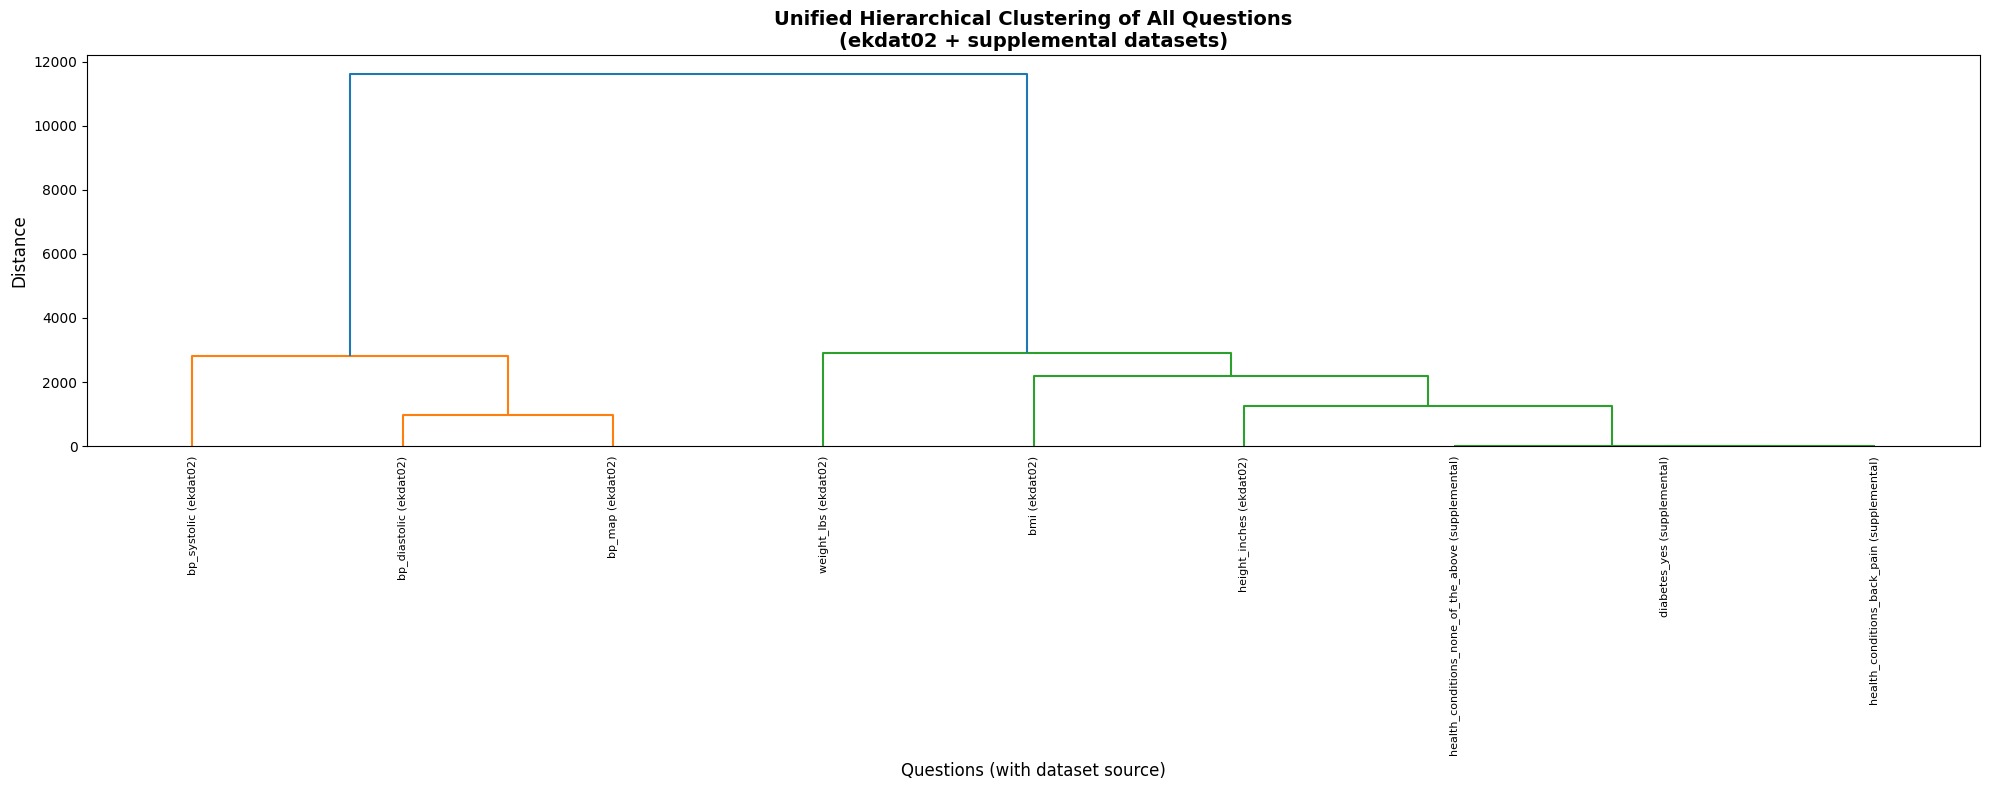

✅ Unified dendrogram created successfully!
Questions clustered: 9
Samples used: 5000


In [17]:
# Create unified dendrogram with all questions from both datasets
print("Creating unified clustering with all questions from both datasets...")

# Get question columns from both datasets
ekdat02_questions = set(ekdat02_X.columns)
supp_questions = set(supp_X.columns)
all_questions = sorted(ekdat02_questions.union(supp_questions))

print(f"Total unique questions across both datasets: {len(all_questions)}")
print(f"Questions from ekdat02: {len(ekdat02_questions)}")
print(f"Questions from supplemental: {len(supp_questions)}")

# Create combined matrix
print("Creating combined matrix...")

# For ekdat02: add missing columns (from supplemental) with zeros
ekdat02_combined = ekdat02_X.copy()
for q in supp_questions:
    if q not in ekdat02_combined.columns:
        ekdat02_combined[q] = 0

# For supplemental: add missing columns (from ekdat02) with zeros  
supp_combined = supp_X.copy()
for q in ekdat02_questions:
    if q not in supp_combined.columns:
        supp_combined[q] = 0

# Ensure both have same column order
ekdat02_combined = ekdat02_combined[all_questions]
supp_combined = supp_combined[all_questions]

# Combine the datasets
import pandas as pd
combined_X = pd.concat([ekdat02_combined, supp_combined], axis=0, ignore_index=True)

print(f"Combined matrix shape: {combined_X.shape}")

# Sample if too large for clustering
max_samples = 5000
if len(combined_X) > max_samples:
    print(f"Sampling {max_samples} rows from {len(combined_X)} total rows...")
    combined_X_sample = combined_X.sample(n=max_samples, random_state=42)
else:
    combined_X_sample = combined_X

print(f"Final matrix for clustering: {combined_X_sample.shape}")

# Remove questions with no variation (all zeros or all same value)
print("Filtering questions with variation...")
question_vars = combined_X_sample.var()
active_questions_unified = question_vars[question_vars > 0].index
print(f"Questions with variation: {len(active_questions_unified)} out of {len(all_questions)}")

if len(active_questions_unified) == 0:
    print("ERROR: No questions have variation - cannot perform clustering")
else:
    # Filter to active questions
    X_unified = combined_X_sample[active_questions_unified]
    
    # Transpose for question clustering
    X_t_unified = X_unified.T
    
    print(f"Clustering {X_t_unified.shape[0]} questions...")
    
    # Perform hierarchical clustering
    from scipy.cluster.hierarchy import dendrogram, linkage
    Z_unified = linkage(X_t_unified, method='ward')
    
    # Create labels showing dataset source
    question_labels = []
    for q in active_questions_unified:
        if q in ekdat02_questions and q in supp_questions:
            source = "BOTH"
        elif q in ekdat02_questions:
            source = "ekdat02"
        else:
            source = "supplemental"
        question_labels.append(f"{q} ({source})")
    
    # Create dendrogram
    plt.figure(figsize=(20, 8))
    dendrogram(Z_unified, 
               labels=question_labels,
               leaf_rotation=90,
               leaf_font_size=8)
    plt.title('Unified Hierarchical Clustering of All Questions\n(ekdat02 + supplemental datasets)', 
              fontsize=14, fontweight='bold')
    plt.xlabel('Questions (with dataset source)', fontsize=12)
    plt.ylabel('Distance', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    print(f"✅ Unified dendrogram created successfully!")
    print(f"Questions clustered: {len(active_questions_unified)}")
    print(f"Samples used: {len(combined_X_sample)}")